## Data Formatting
El paso final antes de alimentar nuestro modelos es obtener slices de tiempo con funciones de agregación de tipo ```sum```, ```count```, etc. Pero además es importante obtener una serie temporal continua, y para ello es necesario tomar las siguientes consideraciones:
- tomar el periodo posterior a la cuarentena por *SARS-CoV-2*.
- quitar los días sin o con baja producción, 
- quitar horarios no laborales.

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Set max columns
pd.set_option('display.max_columns', None)
DATADIR = 'data/2020/'
MODELS = 'models/'
# Set paths
DATASET = os.path.join(DATADIR, '2020_imp.csv')

In [3]:
plt.style.use('seaborn-whitegrid')

# Carga de datos

In [4]:
df = pd.read_csv(DATASET, index_col=[0])

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,7,8,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df.index = pd.to_datetime(df.DECL)

In [6]:
df.DPTO = df.DPTO.replace({'MONTVU':'MONT'})

In [7]:
df.PJI = df.PJI.astype(str)

In [8]:
df['ID'] = np.arange(len(df))

In [9]:
freq = 'H'
dphu = df.resample(freq).nunique()['ID'].to_frame().join(df.resample(freq).nunique()['PJI'].to_frame())
#v2 = v2.resample(freq).nunique()['ID'].to_frame().join(v1.resample(freq).nunique()['PJI'].to_frame())

In [10]:
def step(x):
    return 1 * (x > 0)

### Gráfico de identificación de intermitencia temporal

<AxesSubplot:xlabel='DECL'>

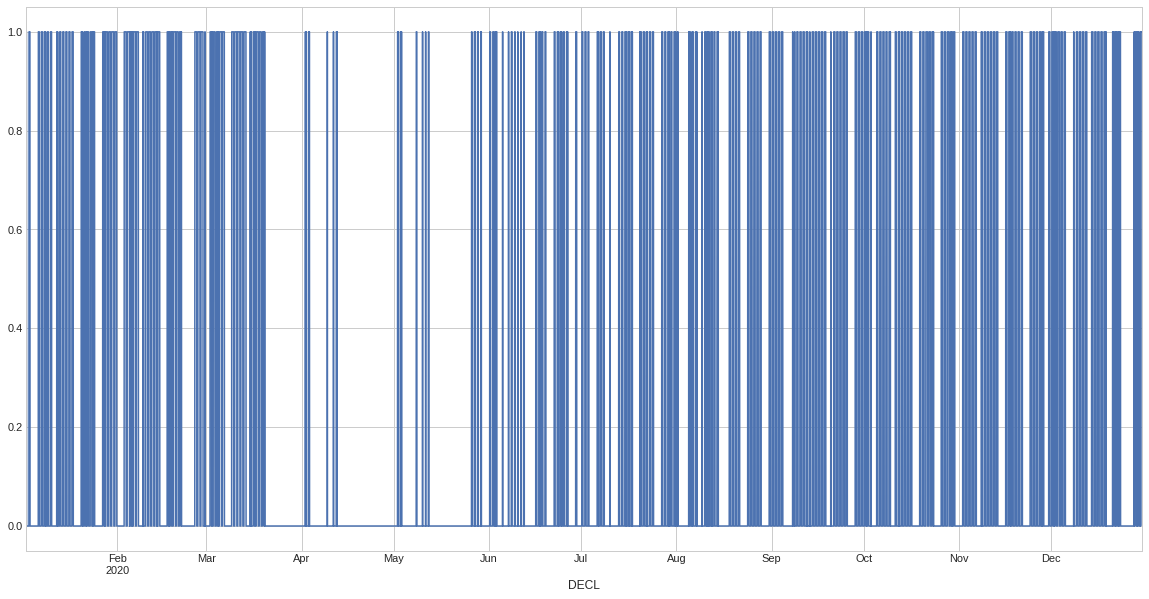

In [11]:
step((dphu.ID/dphu.PJI)).plot(figsize=(20,10))

**DPHU**

Una métrica utilizada en fabricación es la cantidad de defectos por hora por vehículo
$$ DPHU = \frac{def_{hs}}{veh_{hs}}$$

In [12]:
dphu['DPU'] = dphu.ID/dphu.PJI

<AxesSubplot:xlabel='DECL'>

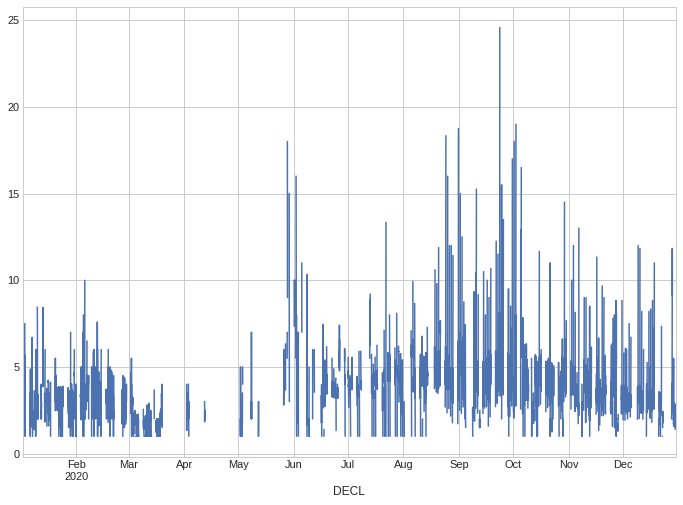

In [13]:
dphu.DPU.plot()

### Obtención de dataset definitivo
Se realiza un muestreo diario de la cantidad de defectos a partir de mayo de 2020, luego se obtiene el *dataframe*. El objetivo es obtener los días en los que realmente hubo producción, esto lo podemos deducir poniendo un mínimo en la cantidad de defectos encontrados."

In [14]:
start_date = '2020-05-12'

In [15]:
dphu

,ID,PJI,DPU
DECL,,,
2020-01-02 06:00:00,3,1,3.000000
2020-01-02 07:00:00,76,7,10.857143
2020-01-02 08:00:00,19,2,9.500000
2020-01-02 09:00:00,24,4,6.000000
2020-01-02 10:00:00,2,1,2.000000
...,...,...,...
2020-12-30 10:00:00,74,26,2.846154
2020-12-30 11:00:00,36,15,2.400000
2020-12-30 12:00:00,44,17,2.588235


In [16]:
# Slice df by day
dailydf = dphu.loc[start_date:].resample('D')['ID'].sum().to_frame()

In [17]:
# Days with 300 or over defects
dailydf = dailydf[dailydf.ID>300]

In [18]:
from dateutil import parser

start_hour = 5
end_hour = 13

def workable_filter(row):
    ''' Check if hour of datetime is workable '''
    hour = row.name.hour
    if start_hour < hour < end_hour:
        return True
    else:
        return False

In [19]:
def prodnormal_filter(df):
    # Normal day of production
    df = df[df.index.floor('D').isin(dailydf.index)]
    # Hs of production
    df = df[df.apply(lambda row: workable_filter(row), axis=1)].reset_index()
    return df

In [20]:
dphu_norm = prodnormal_filter(dphu).fillna(0)

## Serie temporal univariada

Usaremos como *feature* DPU para entrenar dos tipos de modelos, **CNN dilatada** y **RNN**. No se espera que su rendimiento sea óptimo ya que solo esta usando los ```T``` valores anteriores para predecir los siguientes ```HORIZON``` valores.

In [21]:
dphu_norm.head()

,DECL,ID,PJI,DPU
0,2020-06-16 06:00:00,20,6,3.333333
1,2020-06-16 07:00:00,33,14,2.357143
2,2020-06-16 08:00:00,49,20,2.450000
3,2020-06-16 09:00:00,37,21,1.761905
4,2020-06-16 10:00:00,74,28,2.642857


<AxesSubplot:xlabel='DECL'>

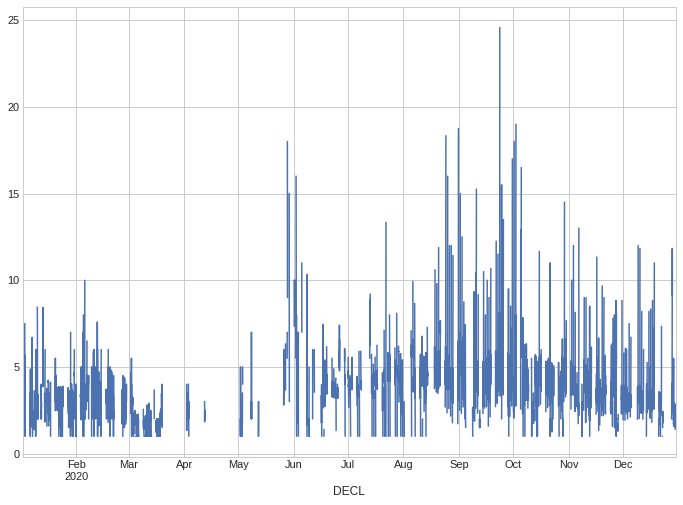

In [22]:
dphu.DPU.plot()

In [23]:
hourdf = df.loc['2020-05-12':].resample('15min')['AUDI'].count().to_frame()

<ipython-input-23-d6f4cac5907b>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  hourdf = df.loc['2020-05-12':].resample('15min')['AUDI'].count().to_frame()


<ipython-input-24-d42f6deb68d1>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df.loc['2020-05-12':].resample('15min')['AUDI'].count().to_frame().reset_index().AUDI.plot(figsize=(20,10))


<AxesSubplot:>

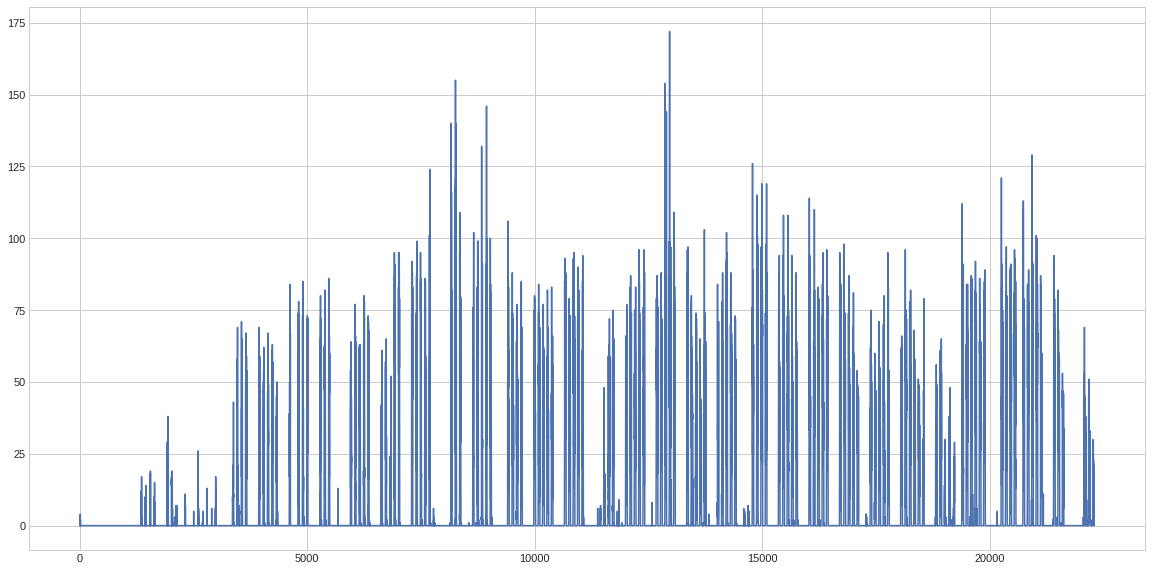

In [24]:
df.loc['2020-05-12':].resample('15min')['AUDI'].count().to_frame().reset_index().AUDI.plot(figsize=(20,10))

In [25]:
dphu = dphu[dphu.index.floor('D').isin(dailydf.index)]

In [26]:
hourdf = hourdf[hourdf.index.floor('D').isin(dailydf.index)]

In [27]:
hourdf

,AUDI
DECL,
2020-06-16 00:00:00,0
2020-06-16 00:15:00,0
2020-06-16 00:30:00,0
2020-06-16 00:45:00,0
2020-06-16 01:00:00,0
...,...
2020-12-30 13:30:00,0
2020-12-30 13:45:00,1
2020-12-30 14:00:00,1


In [28]:
prodnormal_filter(hourdf).to_csv('univariate.csv', index=False)

<AxesSubplot:>

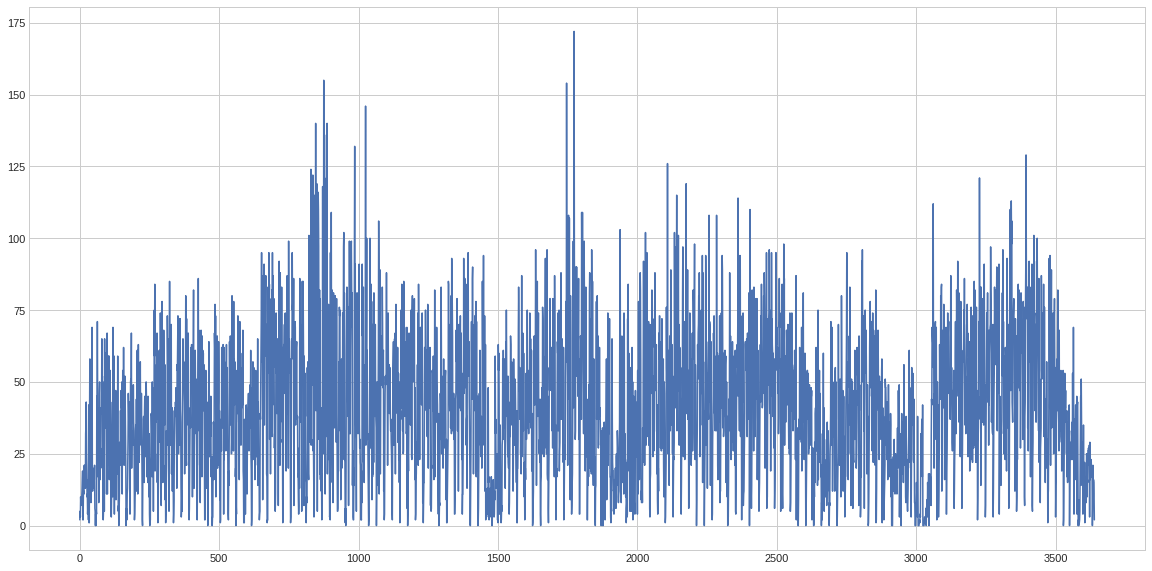

In [29]:
prodnormal_filter(hourdf).AUDI.plot(figsize=(20,10))

<AxesSubplot:xlabel='DECL'>

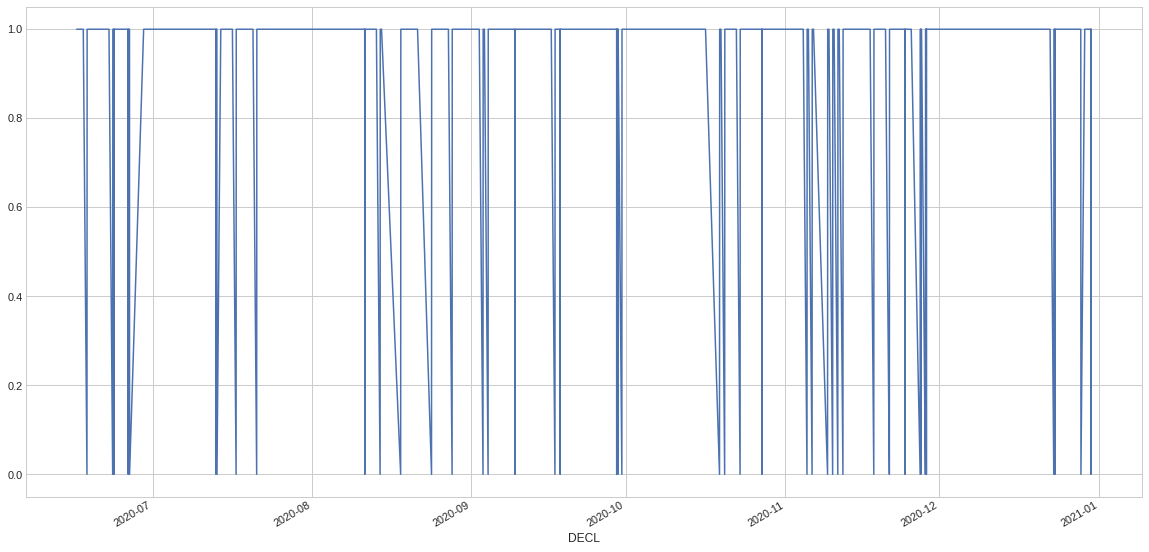

In [30]:
step(prodnormal_filter(hourdf).set_index('DECL')).plot(figsize=(20,10), legend=False)

<AxesSubplot:>

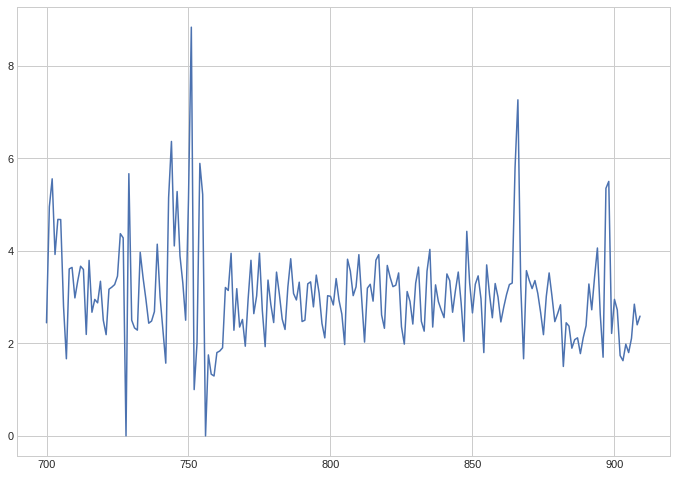

In [31]:
dphu_norm.DPU.iloc[700:].plot()

In [32]:
dphu_norm

,DECL,ID,PJI,DPU
0,2020-06-16 06:00:00,20,6,3.333333
1,2020-06-16 07:00:00,33,14,2.357143
2,2020-06-16 08:00:00,49,20,2.450000
3,2020-06-16 09:00:00,37,21,1.761905
4,2020-06-16 10:00:00,74,28,2.642857
...,...,...,...,...
905,2020-12-30 08:00:00,81,45,1.800000
906,2020-12-30 09:00:00,78,37,2.108108
907,2020-12-30 10:00:00,74,26,2.846154
908,2020-12-30 11:00:00,36,15,2.400000


## Serie temporal multivariada
En segunda instancia se creará un dataset con varias *features* con el objetivo de alimentar a dos redes, **CNN dilatada** y **RNN**. Se espera que su rendimiento superé con creces a la univariada.

In [33]:
# Group by week, gravity and audit
#test = df.groupby([df.index.date, df['UET'], df['TALL'], df['DPTO']]).nunique()
df = df[df.index>start_date]

In [34]:
# Group by day, hour, minute and dpto
dpto = df.groupby([df.index.date, df.index.hour, df.index.minute, df['DPTO']]).nunique()['ID'].unstack(level=-1).fillna(0)
# Group by day, hour, minute and type
tipo = df.groupby([df.index.date, df.index.hour, df.index.minute, df['TIPO']]).nunique()['ID'].unstack(level=-1).fillna(0)
# Group by day, hour, minute and defects
dftos = df.groupby([df.index.date, df.index.hour, df.index.minute]).nunique()['ID'].fillna(0).to_frame().rename(columns={'ID':'DEF'})

In [35]:
dftos

DEF
           DECL DECL     
2020-05-12 7    23      3
           8    9       1
           9    17      3
           10   6       4
                54      2
...                   ...
2020-12-30 13   26      1
                54      1
           14   1       1
                27      1
                35      1

[35977 rows x 1 columns]

<AxesSubplot:xlabel='None,DECL,DECL'>

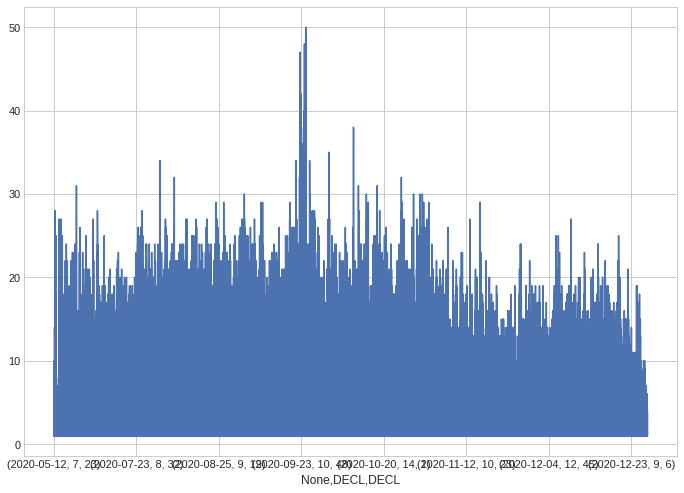

In [36]:
dftos.DEF.plot()

In [37]:
dataset = dftos.join(dpto.join(tipo))

## Plotting dptos

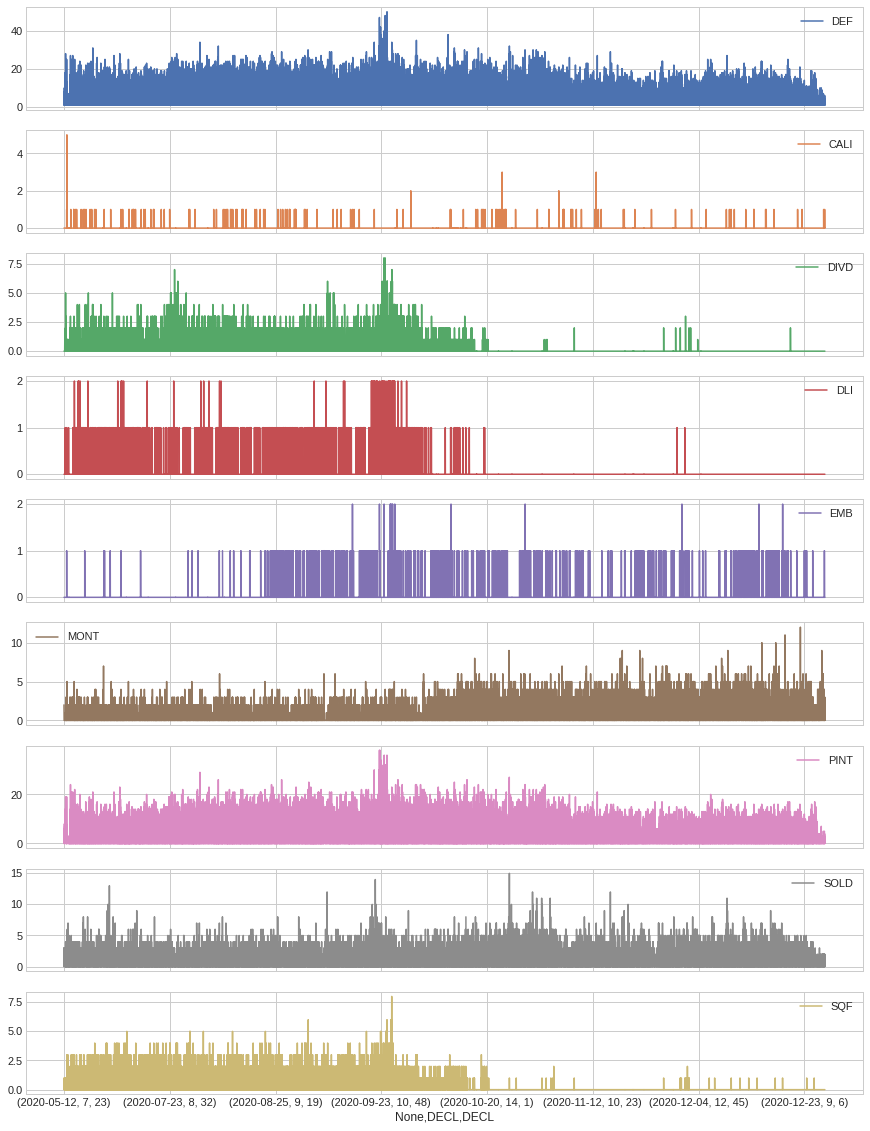

In [43]:
# Select features to plot
features_plot = list(dataset.columns)[:9]

# Dptos features
df_plot = dataset[features_plot]
df_plot.index = dataset.index
_ = df_plot.plot(subplots=True, figsize=(15,20))
#fig = plot.get_figure()
#fig.savefig("output.png")

## Plotting flia

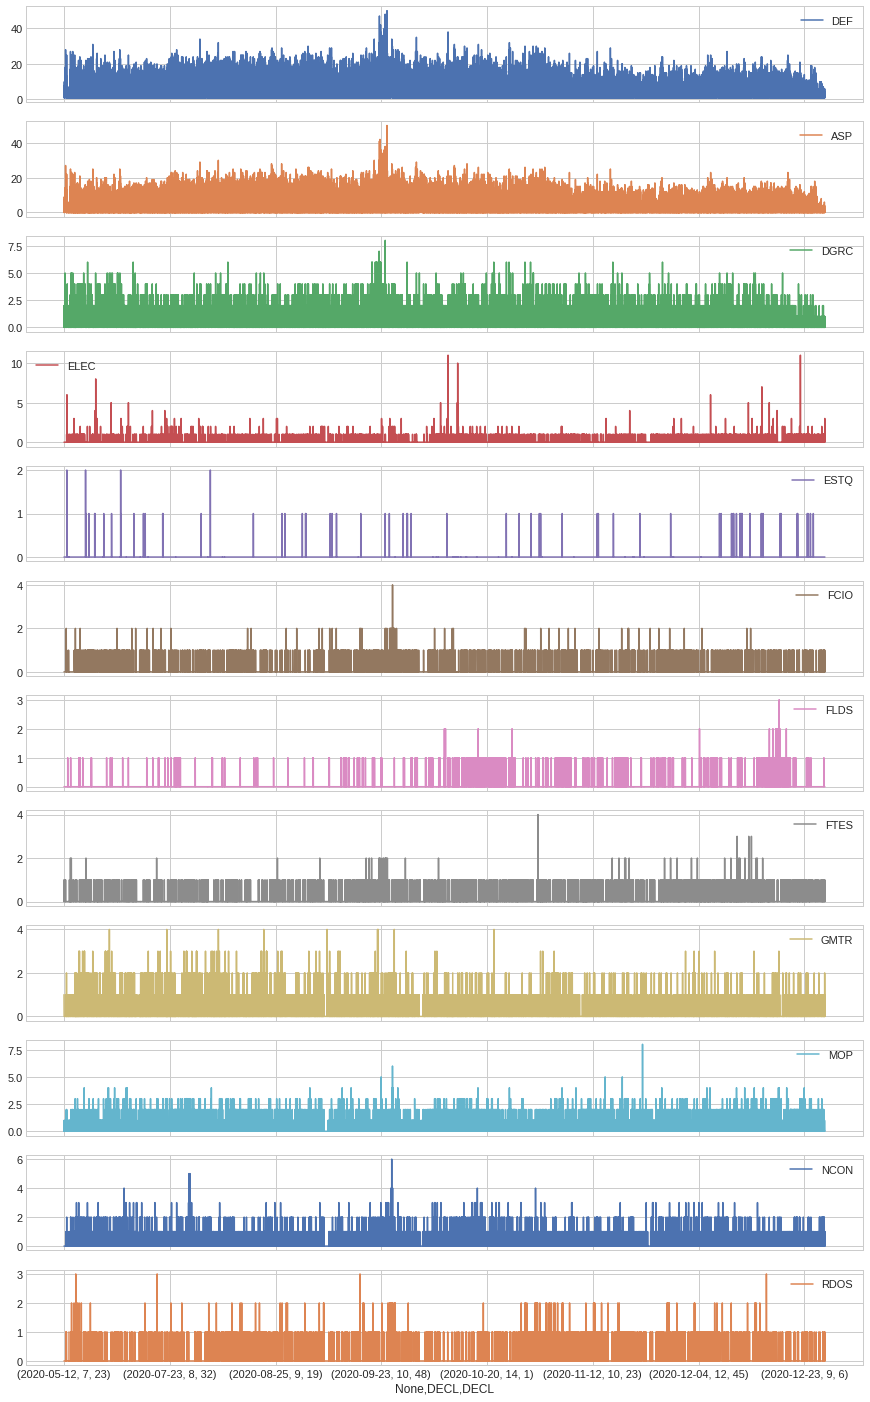

In [48]:
features_plot = ['DEF']
features_plot.extend(list(dataset.columns)[10:])
# Flia features
df_plot = dataset[features_plot]
df_plot.index = dataset.index
_ = df_plot.plot(subplots=True, figsize=(15,25))

Se guarda y se vuelve a cargar por el desconocimiento para desemsamblar los índices.

In [49]:
dataset.to_csv('dataset.csv')

In [50]:
data = pd.read_csv('dataset.csv')

In [51]:
data['FECHA'] = data['Unnamed: 0'].astype(str) + ' ' + data['DECL'].astype(str).str.zfill(2) + ':' + data['DECL.1'].astype(str).str.zfill(2) +':00'

In [52]:
data.drop(columns=['Unnamed: 0', 'DECL', 'DECL.1',], inplace=True)

In [53]:
data

,DEF,CALI,DIVD,DLI,EMB,MONT,PINT,SOLD,SQF,APR,ASP,DGRC,ELEC,ESTQ,FCIO,FLDS,FTES,GMTR,MOP,NCON,RDOS,FECHA
0,3,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2020-05-12 07:23:00
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-05-12 08:09:00
2,3,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2020-05-12 09:17:00
3,4,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2020-05-12 10:06:00
4,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-05-12 10:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35972,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-30 13:26:00
35973,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-12-30 13:54:00
35974,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2020-12-30 14:01:00
35975,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-30 14:27:00


In [54]:
data.index = pd.to_datetime(data['FECHA'])#, format='%Y-%m-%d %H:%M:%S')

In [55]:
data.drop(columns='FECHA', inplace=True)

In [56]:
data

,DEF,CALI,DIVD,DLI,EMB,MONT,PINT,SOLD,SQF,APR,ASP,DGRC,ELEC,ESTQ,FCIO,FLDS,FTES,GMTR,MOP,NCON,RDOS
FECHA,,,,,,,,,,,,,,,,,,,,,
2020-05-12 07:23:00,3,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-05-12 08:09:00,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-12 09:17:00,3,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2020-05-12 10:06:00,4,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2020-05-12 10:54:00,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 13:26:00,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-30 13:54:00,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-12-30 14:01:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [57]:
data = data.resample('15min').sum()

In [59]:
data = data[data.index.floor('D').isin(dailydf.index)]

In [61]:
data = data[data.apply(lambda row: workable_filter(row), axis=1)].reset_index(drop=True)#.drop(columns='FECHA')

In [62]:
data

,DEF,CALI,DIVD,DLI,EMB,MONT,PINT,SOLD,SQF,APR,ASP,DGRC,ELEC,ESTQ,FCIO,FLDS,FTES,GMTR,MOP,NCON,RDOS
0,2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,10,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,9,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3636,16,0.0,0.0,0.0,1.0,6.0,6.0,3.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3637,15,0.0,0.0,0.0,0.0,4.0,7.0,4.0,0.0,0.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,1.0
3638,11,1.0,0.0,0.0,0.0,0.0,7.0,3.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


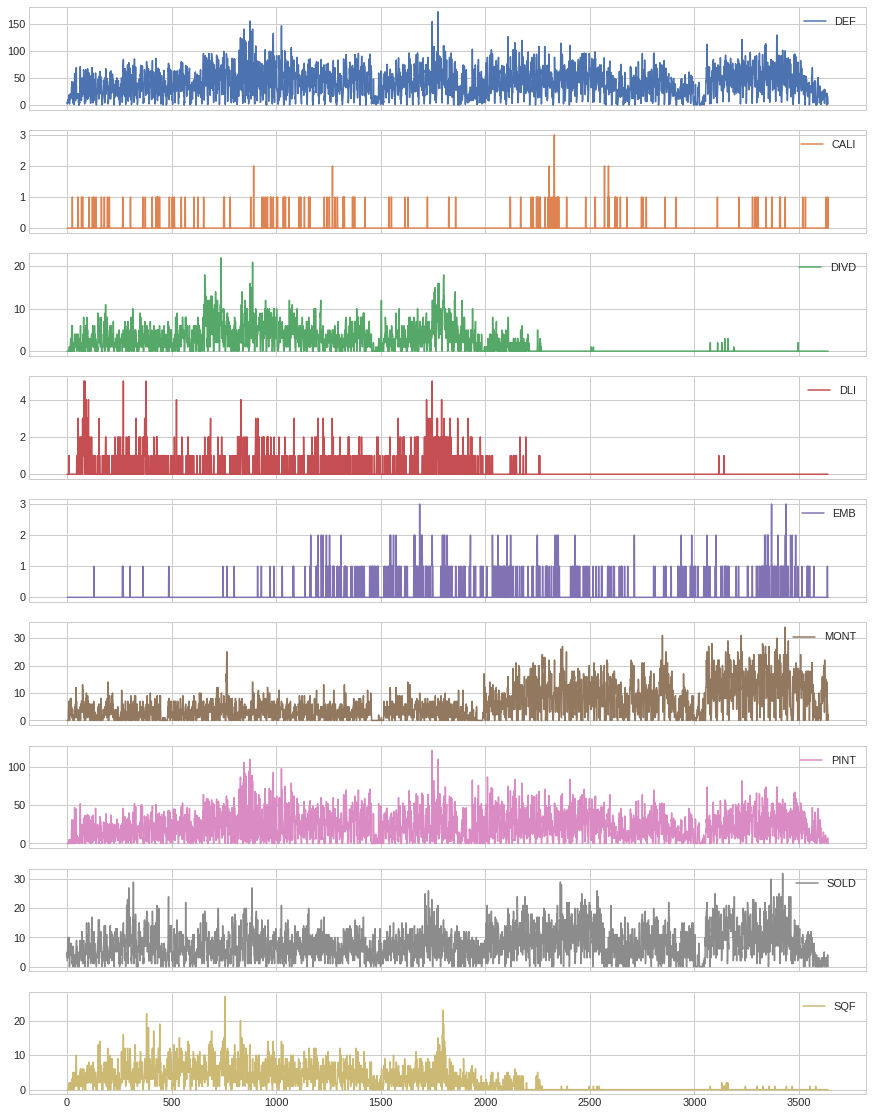

In [68]:
# Select features to plot
features_plot = list(data.columns)[:9]

# Dptos features
df_plot = data[features_plot]
df_plot.index = data.index
_ = df_plot.plot(subplots=True, figsize=(15,20))

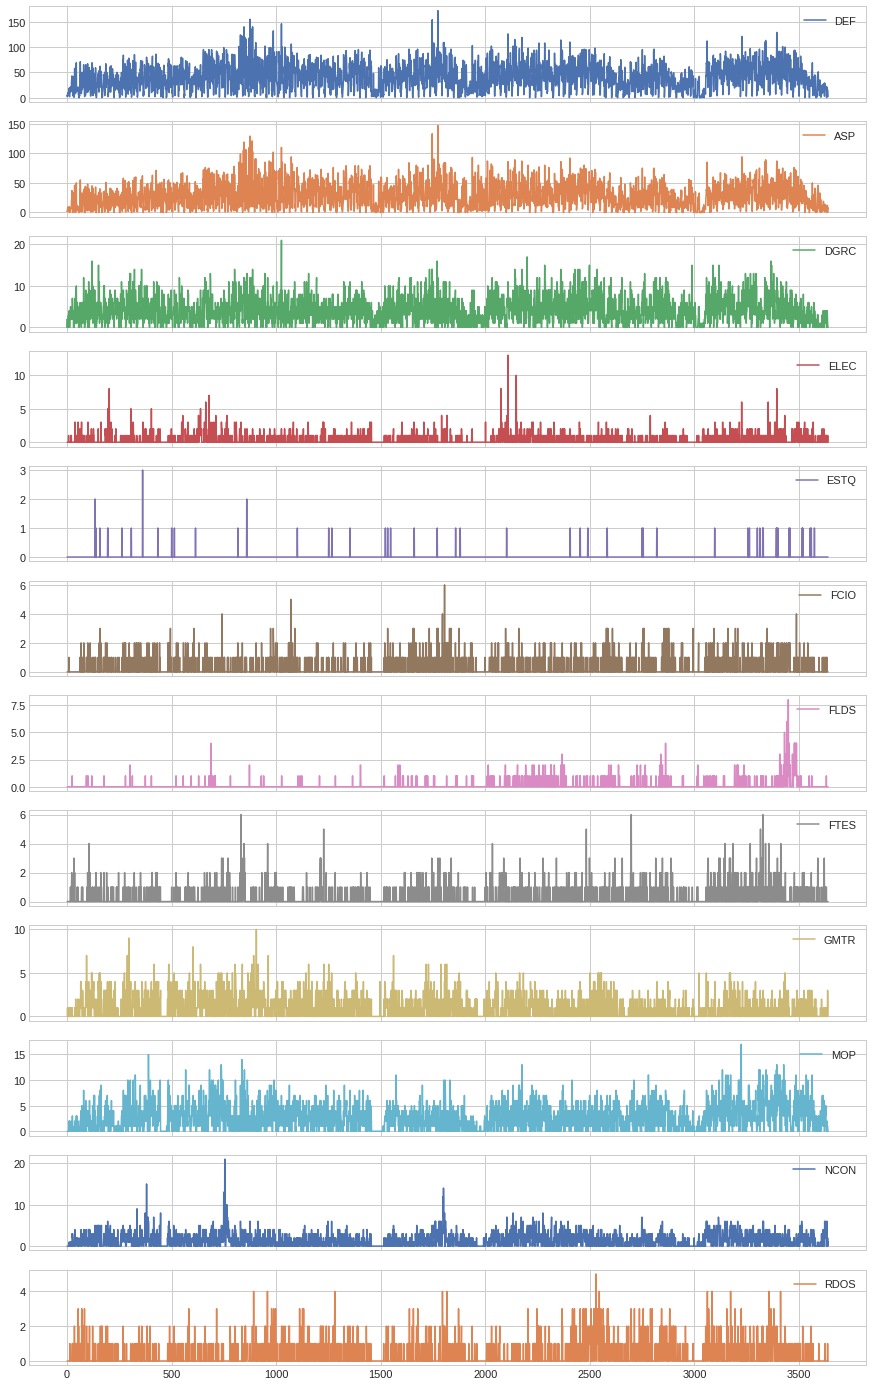

In [70]:
features_plot = ['DEF']
features_plot.extend(list(data.columns)[10:])
# Flia features
df_plot = data[features_plot]
df_plot.index = data.index
_ = df_plot.plot(subplots=True, figsize=(15,25))

In [79]:
data = data.astype(int)

In [80]:
data.to_csv('multivariate.csv', index=False)